# Bayesian SIR Model with Change Points

In [1]:
import numpy as np
from scipy.stats import binom, gamma, beta, expon, poisson, uniform, bernoulli
from joblib import Parallel, delayed
from scipy.special import gamma as gammaFunc
import random

import pandas as pd
import matplotlib.pyplot as plt

import tqdm
import itertools

## Data Simulation

In [2]:
def sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets):

    N = S0 + I0 + R0
    n_sc = scenarios.shape[0]

    # create array of transmission and removal rate parameters at each time step
    beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
    gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])


    Delta_I = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    Delta_R = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    S       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    I       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    R       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)

    Delta_I[:,:,0] = binom.rvs(S0, 1-np.exp(-beta[:,0]*I0/N), size=(n_datasets, n_sc))
    Delta_R[:,:,0] = binom.rvs(I0, gamma[:,0], size=(n_datasets, n_sc))
    S[:,:,0]       = S0 - Delta_I[:,:,0]
    I[:,:,0]       = I0 + Delta_I[:,:,0] - Delta_R[:,:,0]
    R[:,:,0]       = R0 + Delta_R[:,:,0]

    for t in range(1, T):
        Delta_I[:,:,t] = binom.rvs(S[:,:,t-1], 1-np.exp(-beta[:,t]*I[:,:,t-1]/N))
        Delta_R[:,:,t] = binom.rvs(I[:,:,t-1], gamma[:,t])
        S[:,:,t]       = S[:,:,t-1] - Delta_I[:,:,t]
        I[:,:,t]       = I[:,:,t-1] + Delta_I[:,:,t] - Delta_R[:,:,t]
        R[:,:,t]       = R[:,:,t-1] + Delta_R[:,:,t]

    return Delta_I, Delta_R, S, I, R

In [3]:
def plot_SRI(S, I, R, sc=0, d=None, start_cond=(999_950, 50, 0), tot=1_000_000, time=100):

    if d is None:
        S = np.expand_dims(np.mean(S, axis=0), 0)
        I = np.expand_dims(np.mean(I, axis=0), 0)
        R = np.expand_dims(np.mean(R, axis=0), 0)
        d = 0

    S = np.concatenate([[start_cond[0]], S[d,sc]])
    I = np.concatenate([[start_cond[1]], I[d,sc]])
    R = np.concatenate([[start_cond[2]], R[d,sc]])

    # plot
    fig, ax = plt.subplots()

    y = np.vstack([S, I, R])
    ax.stackplot(np.arange(time+1), y/tot, labels=["S","I","R"], alpha=0.8)

    ax.set_xlabel("Day")
    ax.set_ylabel("Proportion")
    ax.set_xticks(np.concatenate([[0], np.arange(25, time+1, 25)]))
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend(loc="upper right")

    plt.show()

### Example

In [4]:
T = 100
N = 1_000_000

chg_pt = np.array([26, 51, 76])

sc_1 = [(0.3, 0.05), (0.4, 0.15), (0.25, 0.2),  (0.2,  0.25)]
sc_2 = [(0.4, 0.1),  (0.4, 0.25), (0.25, 0.25), (0.25, 0.4) ]
sc_3 = [(0.5, 0.1),  (0.3, 0.3),  (0.4,  0.2),  (0.2,  0.4) ]
scenarios = np.array([sc_1, sc_2, sc_3])

S0 = N-50
I0 = 50
R0 = 0

n_datasets = 100

Scenario 1:


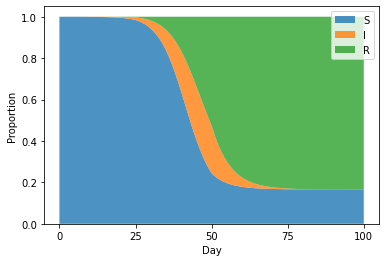

Scenario 2:


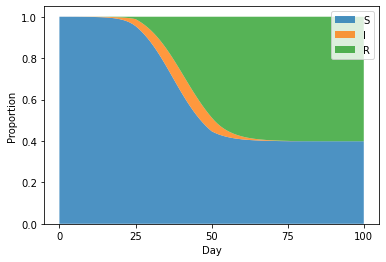

Scenario 3:


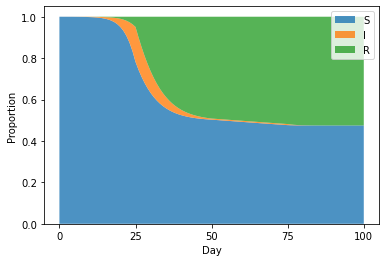

In [5]:
Delta_I, Delta_R, S, I, R =  sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets)
for i in range(len(scenarios)):
    print(f"Scenario {i+1}:")
    plot_SRI(S, I, R, sc=i)

## Gibbs Sampling

In [6]:
S_obs = np.concatenate(([S0],S[0,0]))
I_obs = np.concatenate(([I0],I[0,0]))
R_obs = np.concatenate(([R0],R[0,0]))
PI_obs = I_obs/N
N_infect_obs = np.concatenate(([I0],Delta_I[0,0]))
N_recovery_obs = np.concatenate(([R0],Delta_R[0,0]))

data = pd.DataFrame({
        'susceptible': S_obs,
        'infects': I_obs,
        'recovered': R_obs,
        'PI': PI_obs,
        'deltaI': N_infect_obs,
        'deltaR': N_recovery_obs
    })

In [7]:
data

,susceptible,infects,recovered,PI,deltaI,deltaR
0,999950,50,0,0.000050,50,0
1,999940,56,4,0.000056,10,4
2,999923,68,9,0.000068,17,5
3,999899,92,9,0.000092,24,0
4,999870,116,14,0.000116,29,5
...,...,...,...,...,...,...
96,167452,14,832534,0.000014,0,9
97,167452,11,832537,0.000011,0,3
98,167452,8,832540,0.000008,0,3
99,167452,7,832541,0.000007,0,1


### Functions

In [29]:
def delta_sampling(Delta_hat,Stage_hat,K_hat,p,beta_hat,gamma_hat):
    
    ########## change type
    ## add–delete–swap - proposal step
    # -1 delete
    # 0 swap
    # +1 add
    if K_hat==1:
            change_type = 1
        
    elif K_hat==T_max:
        change_type = -1

    else:
        change_type = np.random.choice([-1, 0, 1])
            
    Delta_hat_candidate = Delta_hat.copy()
    
    ########## proposal phase
    if change_type != 0:
        if change_type == 1:
            possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
        if change_type == -1:
            possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
            
        index_to_change = np.random.choice(possible_change_indices)
            
        Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
        Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
            
    else:
    
        possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
        one_index = Delta_hat[possible_change_indices]
        index_to_change = np.random.choice(possible_change_indices)

        Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]
        Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
    
    #print("Original:",np.where(Delta_hat==1)[0])
    #print("Candidate:",np.where(Delta_hat_candidate==1)[0])
    #print("---------------------------")
    
    ########## metropolis hastings phase
    #compute pi(delta*)/pi(delta^g)
    pi = (p/(1-p))**(np.sum(Delta_hat_candidate - Delta_hat))
        
    #compute J/J
    JJ = 0
    delta_sum_candidate = np.sum(Delta_hat_candidate)
    delta_sum = np.sum(Delta_hat)
    if delta_sum == delta_sum_candidate:
        JJ = 1 
    elif ([delta_sum_candidate, delta_sum] == [1, 2] or [delta_sum_candidate, delta_sum] == [T_max, T_max-1]):
        JJ = 3/(T_max-1)
    elif ([delta_sum_candidate, delta_sum] == [2, 1] or [delta_sum_candidate, delta_sum] == [T_max-1, T_max]):
        JJ = (T_max-1)/3
    elif delta_sum_candidate - delta_sum == -1 and (delta_sum_candidate != 1 and delta_sum_candidate != T_max-1):
        JJ = (delta_sum-1)/(T_max - delta_sum_candidate)
    elif delta_sum_candidate - delta_sum == 1 and (delta_sum_candidate != 2 and delta_sum_candidate != T_max):
        JJ = (T_max - delta_sum)/(delta_sum_candidate-1)

    #compute pi(beta,gamma|delta*)/pi(beta,gamma|delta)
    log1_candidate = 0
    log2_candidate = 0
        
    for k in range(np.sum(Delta_hat_candidate)):
        ind_k = np.where(Stage_hat_candidate == k)[0]
        log1_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
        log2_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
        
    log1_original = 0
    log2_original = 0
                                     
    for k in range(np.sum(Delta_hat)):
        ind_k = np.where(Stage_hat == k)[0]
        
        log1_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
        log2_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
        
    log_final = (log1_candidate+log2_candidate) - (log1_original+log2_original)     
        
    intermediate_ratio = np.exp(log_final)
    m_mh = intermediate_ratio*JJ*pi
    ratio = min(1.,m_mh)
    #print("ratio:",ratio)
    #print("intermediate_ratio:",intermediate_ratio)
    #print("JJ:",JJ)
    #print("pi:",pi)
    #print("likelihood_original:",np.exp(log1_original+log2_original))
    cxx = np.random.binomial(1, ratio) 
        
    if cxx == 1:
        Delta_hat = Delta_hat_candidate
        Stage_hat = Stage_hat_candidate
        K_hat = delta_sum_candidate
        
    return Delta_hat,Stage_hat,K_hat

In [30]:
def calculate_contact_hat_parallel(pp_lambda_t):
    pp, lambda_t = pp_lambda_t
    return np.sum(poisson.ppf(pp, lambda_t))

### Gibbs

In [38]:
def gibbs_sampling(data, p=0.01,samples=10000, T_max=100, burnin=1000, thinning=10):
    
    ############# data
    # Data is expected to be a dataframe with 101 rows (100 steps + initial one)
    # OBS: the initial row should display the starting values 
    #      for Susceptible (S), Infected (I), and Recovered (R), with zero values in the 
    #      columns representing changes (deltas) over time.
    
    I_obs = data["infects"].values
    S_obs = data["susceptible"].values
    PI_obs = data["PI"].values
    N_infect_obs = data["deltaI"].values[1:]
    N_recovery_obs = data["deltaR"].values[1:]
    

    #######################
    ##  HYPERPARAMETERS  ##
    #######################
    
    b_shape = 0.1
    b_rate = 0.1
    r_shape = 0.1
    r_rate = 0.1    

    ######################
    ##  INITIALIZATION  ##
    ######################
    
    ##### delta
    #Delta_hat = np.zeros(T_max,dtype=int)
    #Delta_hat[0] = 1
    
    Delta_hat = np.zeros(25,dtype=int)
    Delta_hat[0] = 1
    Delta_hat = np.tile(Delta_hat,4)
    Stage_hat = np.cumsum(Delta_hat, dtype=int)-1
    K_hat     = np.sum(Delta_hat, dtype=int)
    
    ##### b and r
    b_hat    = gamma.rvs(a=b_shape, scale=1/b_rate, size=K_hat)
    r_hat    = gamma.rvs(a=r_shape, scale=1/r_rate, size=K_hat)
    
    ##### beta and gamma
    beta_hat    = expon.rvs(scale=1/b_hat[Stage_hat[0]], size=T_max)
    gamma_hat   = beta.rvs(a=r_hat[Stage_hat[0]], b=1, size=T_max)
    lambda_t    = beta_hat*PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    
    beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
    gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
    lambda_t    = beta_hat * PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    print("Initialization:\n")
    print("Delta_hat:",Delta_hat)
    print("b_hat:",b_hat)
    print("r_hat:",r_hat)
    print("beta_hat:",beta_hat)
    print("gamma_hat:",gamma_hat)
    print("----------------------------------------------------")
    print("----------------------------------------------------")
    

    ################
    ##  SAMPLING  ##
    ################
    
    Delta_all = []
    Stage_all = []
    b_all     = []
    r_all     = []
    beta_all  = []
    gamma_all = []
    
    for step in tqdm.tqdm(range(samples)):
        
        ###### delta_hat sampling
                
        #Delta_hat, Stage_hat, K_hat = delta_sampling(Delta_hat,Stage_hat,K_hat,p,beta_hat,gamma_hat)
                                  
        ##### b and r sampling
        
        b_hat = np.zeros(K_hat)
        r_hat = np.zeros(K_hat)
        for i in range(K_hat):
            L_i = np.where(Stage_hat == i)[0]
            b_hat[i] = gamma.rvs(size=1, a=(b_shape + len(L_i)), scale=1/(b_rate + np.sum(beta_hat[L_i])))
            r_hat[i] = gamma.rvs(size=1, a=(r_shape + len(L_i)), scale=1/(r_rate + np.sum(-np.log(gamma_hat[L_i]))))
    
        
        ##### beta and gamma sampling

        beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
        gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
        lambda_t    = beta_hat * PI_obs[:-1]
        p_upper     = 1 - poisson.cdf(0, lambda_t)
        pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
        contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))

        if step % 100 == 0 and step != 0:
            print("\nStep:",step)
            #print("Delta_hat:",Delta_hat)
            #print("b_hat:",b_hat)
            #print("r_hat:",r_hat)
            #print("beta_hat:",beta_hat)
            #print("gamma_hat:",gamma_hat)
            print("----------------------------------------------------")
            
        Delta_all.append(Delta_hat)
        Stage_all.append(Stage_hat)
        b_all.append(b_hat)
        r_all.append(r_hat)
        beta_all.append(beta_hat)
        gamma_all.append(gamma_hat)
  
    # Creazione del DataFrame
    MCMC_chain = {
        'Delta': Delta_all[burnin::thinning],
        'Stage': Stage_all[burnin::thinning],
        'b': b_all[burnin::thinning],
        'r': r_all[burnin::thinning],
        'beta': beta_all[burnin::thinning],
        'gamma': gamma_all[burnin::thinning]
            }
    
    return MCMC_chain

In [39]:
MCMC_chain=gibbs_sampling(data, p=0.01,samples=500, burnin=50, thinning=1)

Initialization:

Delta_hat: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
b_hat: [2.28480643e-02 1.43513138e+00 6.52522765e-05 3.85511497e+00]
r_hat: [2.18210724e-01 4.11265593e-10 5.95875882e+00 1.92047867e-02]
beta_hat: [2.33747314e-01 3.25983487e-01 3.42145594e-01 4.21905160e-01
 3.05704976e-01 2.98098964e-01 2.72044595e-01 2.73384222e-01
 2.47122015e-01 2.50681052e-01 2.93167653e-01 3.08024649e-01
 3.12935926e-01 3.52479538e-01 3.35922066e-01 3.00949714e-01
 3.02408262e-01 3.00551531e-01 3.12153357e-01 3.31446428e-01
 3.34859809e-01 3.36284049e-01 3.10542250e-01 3.35424778e-01
 2.97912984e-01 9.14297181e-01 4.32672119e-01 1.57281943e+00
 2.66976662e+00 6.44518792e-01 1.38064211e+00 4.46207783e-01
 4.38754038e-01 7.49514833e-01 7.55892416e-01 2.00775664e+00
 2.71053967e+00 3.84960277e-01 6.32172983e-01 1.28135758e+00
 3.1926822

 20%|█████████▎                                    | 101/500 [03:04<11:31,  1.73s/it]


Step: 100
----------------------------------------------------


 40%|██████████████████▍                           | 201/500 [05:22<05:44,  1.15s/it]


Step: 200
----------------------------------------------------


 60%|███████████████████████████▋                  | 301/500 [07:23<04:40,  1.41s/it]


Step: 300
----------------------------------------------------


 80%|████████████████████████████████████▉         | 401/500 [09:28<02:12,  1.34s/it]


Step: 400
----------------------------------------------------


100%|██████████████████████████████████████████████| 500/500 [11:32<00:00,  1.38s/it]


### Estimators

In [40]:
def compute_loss(delta, Q_tt):
    stage = np.cumsum(delta, dtype=int)-1
    Q_candidate = (stage[:, np.newaxis] == stage)
    return np.sum(np.abs(Q_candidate - Q_tt))

def get_estimators(chain, T_max=100, samples=1000):

    ##### delta

    delta = np.array(MCMC_chain["Delta"])
    stage = np.array(MCMC_chain["Stage"])
    masks = (stage[:, :, np.newaxis] == stage[:, np.newaxis, :])
    Q_ttprime = np.sum(masks, axis=0)/samples

    Delta_final = np.zeros(shape=T_max, dtype=int)
    Delta_final[0] = 1
    Stage_final = np.cumsum(Delta_final, dtype=int)-1 
    current_loss = compute_loss(Delta_final, Q_ttprime)

    check_add_drop = True
    check_swap = True
    while(check_add_drop==True or check_swap==True):
        # check add or drop
        candidates_loss = np.zeros(shape=(T_max))
        for i in range(1, T_max):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[i] = 1-Delta_candidate[i]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss[1:])+1
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_final[index_min] = 1-Delta_final[index_min]
            check_add_drop = True
        else:
            check_add_drop = False

        possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
        candidates_loss = np.zeros(shape=(len(possible_change_indices)))
        for i, idx in enumerate(possible_change_indices):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss)
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
            check_swap = True
        else:
            check_swap = False

        # check swap
        if np.sum(Delta_final) in np.arange(1,T_max-1):
            possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
            candidates_loss = np.zeros(shape=(len(possible_change_indices)))
            for i, idx in enumerate(possible_change_indices):
                Delta_candidate = Delta_final.copy()
                Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
                candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
            index_min = np.argmin(candidates_loss)
            if candidates_loss[index_min] < current_loss:
                current_loss = candidates_loss[index_min]
                Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
                check_swap = True
            else:
                check_swap = False


    ##### beta and gamma
                
    b = np.array([[MCMC_chain["b"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    r = np.array([[MCMC_chain["r"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    beta_final  = np.sum(1/b, axis=0)/samples
    gamma_final = np.sum(r/(1+r), axis=0)/samples


    return Delta_final, beta_final, gamma_final

In [44]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain, 100, 450)
stage_est = np.cumsum(delta_est)-1

In [45]:
T_max=100
delta_true = np.array([(t in chg_pt or t==1) for t in range(1, T_max+1)]).astype(int)
stage_true = np.cumsum(delta_true)-1
print(f"True change points={np.where(delta_true==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

True change points=[ 0 25 50 75]
Predicted change points=[ 0 25 50 75]


In [46]:
gamma_mean = np.mean(np.array(MCMC_chain["gamma"]), axis=0)
beta_mean = np.mean(np.array(MCMC_chain["beta"]), axis=0)

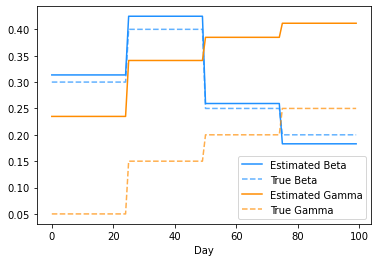

In [47]:
n_sc=3
true_beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
true_gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])

fig, ax = plt.subplots()
plt.plot(beta_est, label="Estimated Beta", color='dodgerblue')
plt.plot(true_beta[0], label="True Beta", color='dodgerblue', linestyle='dashed', alpha=0.7)
plt.plot(gamma_est, label="Estimated Gamma", color='darkorange')
plt.plot(true_gamma[0], label="True Gamma", color='darkorange', linestyle='dashed', alpha=0.7)
ax.set_xlabel("Day")
plt.legend(loc="best")

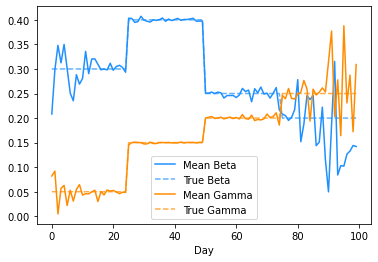

In [48]:
fig, ax = plt.subplots()
plt.plot(beta_mean, label="Mean Beta", color='dodgerblue')
plt.plot(true_beta[0], label="True Beta", color='dodgerblue', linestyle='dashed', alpha=0.7)
plt.plot(gamma_mean, label="Mean Gamma", color='darkorange')
plt.plot(true_gamma[0], label="True Gamma", color='darkorange', linestyle='dashed', alpha=0.7)
ax.set_xlabel("Day")
plt.legend(loc="best")

### Agreement with True Values

In [49]:
def comp_ARI(true, estim, T_max=100):

    comb = np.array(list(itertools.combinations(range(T_max), 2))).T
    true_mask = (true[comb[0]] == true[comb[1]]).astype(int)
    estim_mask = (estim[comb[0]] == estim[comb[1]]).astype(int)

    TP = np.mean(true_mask*estim_mask)
    FP = np.mean((1-true_mask)*estim_mask)
    FN = np.mean(true_mask*(1-estim_mask))
    TN = np.mean((1-true_mask)*(1-estim_mask))
    num = TP+TN-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)
    den = 1-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)

    ARI = num/den

    return ARI


In [50]:
def comp_MI(true, estim, T_max=100):
    n_kkprime = np.histogram2d(true, estim, bins=(np.max(true)+1, np.max(estim)+1))[0]
    n_k = np.sum(n_kkprime, axis=1)
    n_kprime = np.sum(n_kkprime, axis=0)
    
    MI = np.sum(n_kkprime/T_max*np.log((n_kkprime+(n_kkprime==0))*T_max/np.outer(n_k, n_kprime)))
    return MI

In [51]:
ARI = comp_ARI(stage_true, stage_est)
MI = comp_MI(stage_true, stage_est)
print(f"ARI = {ARI} out of 1\nMI = {MI} out of 1.386")

ARI = 1.0 out of 1
MI = 1.3862943611198906 out of 1.386
